# Session 2 Part 1: Going Further, Discovering class-imbalance in datasets

Since we have done the most basic training example, got our hands on skorch and on the dataset, we are going to repeat our process using a more realistic use case. This time, our dataset will be severely unbalanced (10% of all data will be images of aircrafts).

You are going to:
- Do a first "naive" run with the full data
- Diagnose performance
- Try to improve it by tuning several factors:
  - The dataset itself
  - The optimization parameters
  - The network architecture

**Remember that "deep learning" is still considered somewhat a black art so it's hard to know in advance what will work.**


In [1]:
# install dependencies
%pip install skorch

In [0]:
# Put your imports here
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline


import torch
import torch.nn as nn
import torch.optim as optim


from skorch.callbacks import EarlyStopping
from skorch import NeuralNetClassifier

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix

In [0]:
# Global variables
TRAINVAL_DATASET_URL = "https://storage.googleapis.com/isae-deep-learning/trainval_aircraft_dataset.npz"

## Q0. Downloading the dataset

You will get the following:

- 45k images in training which you should use as training & validation
- 15k images in test, which you should only use to compute your final metrics on. Don't ever use this dataset for early stopping

In [0]:
# Download the dataset
ds = np.DataSource("/tmp/")
f = ds.open(TRAINVAL_DATASET_URL, 'rb')
trainval_dataset = np.load(f)


In [0]:
# Split the dataset
train_images = trainval_dataset['train_images']
train_labels = trainval_dataset['train_labels']
test_images = trainval_dataset['test_images']
test_labels = trainval_dataset['test_labels']

## Q1. During Session 1, you learnt how to set up your environment on GCP, train a basic CNN on a small training set and plot metrics. Now let's do it again !

### First run

Once you have downloaded data, use the notebook from Session 1 to get:

a. Visualisation of the data

b. Training of the model using steps seen during Session 1

c. Compute and plot metrics (confusion matrix, ROC curve) based on this training

d. Compare the metrics between this new dataset and the one from Session 1

e. What did you expect ?

In [6]:
# Q1
len(train_images), sum(train_labels), (train_images).shape, sum(test_labels)


(40000, 4086, (40000, 64, 64, 3), 1596)

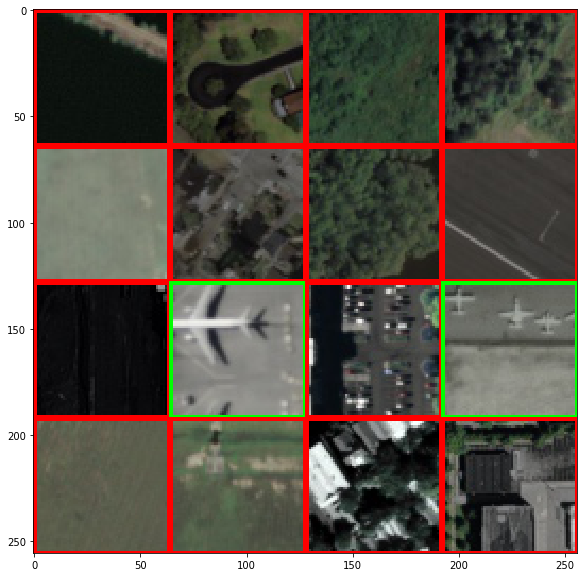

In [7]:


grid_size = 4
grid = np.zeros((grid_size * 64, grid_size * 64, 3)).astype(np.uint8)
for i in range(grid_size):
    for j in range(grid_size):
        tile = np.copy(train_images[i * grid_size + j])
        label = np.copy(train_labels[i * grid_size + j])
        color = (0, 255, 0) if label == 1 else (255, 0, 0)
        tile = cv2.rectangle(tile, (0, 0), (64, 64), color, thickness=2)
        grid[i * 64:(i + 1) * 64, j * 64:(j + 1) * 64, :] = tile

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.imshow(grid)
plt.show()

In [8]:
# Define the torch model to use
# Here a sequential layer is used instead of the classical nn.Module
# If you need to write your own module, plenty of resources are available one the web or in deep learning course
module = nn.Sequential(
    nn.Conv2d(3, 64, 3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 64, 3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 64, 3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(6 * 6 * 64, 256),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 2),
    nn.Softmax(),
)
# Use callbacks
 
early_stopping = EarlyStopping(monitor='valid_loss', lower_is_better=True)

net = NeuralNetClassifier(
    module,
    max_epochs=10,
    lr=0.01,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    callbacks=[early_stopping],
    device="cuda" if torch.cuda.is_available() else "cpu",
    optimizer=optim.SGD)
net.fit(train_images.transpose((0, 3, 1, 2)).astype(np.float32), train_labels)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.2037       0.9466        0.1422  6.5665
      2        0.1228       0.9534        0.1136  6.4976
      3        0.0934       0.9604        0.0936  6.5301
      4        0.0756       0.9580        0.0934  6.5197
      5        0.0660       0.9703        0.0744  6.5746
      6        0.0579       0.9758        0.0573  6.5530
      7        0.0520       0.9773        0.0586  6.5236
      8        0.0462       0.9740        0.0583  6.5344
      9        0.0414       0.9838        0.0458  6.5892
     10        0.0378       0.9816        0.0465  6.5608


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten()
    (13): Linear(in_features=2304, out_features=256, bias=True)
    (14): Linear(in_features=256, out_features=256, bias=True)
    (15): ReLU()
    (16

In [9]:

print("Confusion matrix")
confusion_matrix(test_labels, net.predict(test_images.transpose((0, 3, 1, 2)).astype(np.float32))>0.9)

Confusion matrix


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


array([[13363,    41],
       [  545,  1051]])

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


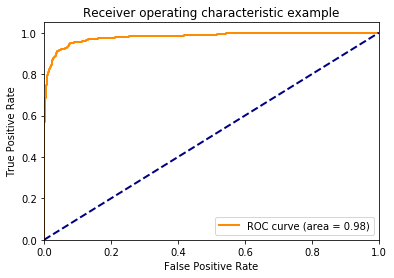

In [10]:

# Compute ROC curve and ROC area for each class
fpr, tpr, t = roc_curve(test_labels, net.predict_proba(test_images.transpose((0, 3, 1, 2)).astype(np.float32))[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

During the previous notebook you plotted the Receiver Operating Characteristic curve. This is not ideal when dealing with imbalanced dataset since the issue of class imbalance can result in a serious bias towards the majority class, reducing the classification performance and increasing the number of **false positives**. Furthermore, in ROC curve calculation, true negatives don't have such meaning any longer.

Instead this time we will plot the Precision Recall curve of our model which uses precision and recall to evaluate models.

![](https://cdn-images-1.medium.com/fit/t/1600/480/1*Ub0nZTXYT8MxLzrz0P7jPA.png)

Refer here for a tutorial on how to plot such curve: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html

More details on PR Curve:
https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

https://www.datascienceblog.net/post/machine-learning/interpreting-roc-curves-auc/

### Imbalanced dataset diagnostics 

e. Can you understand why PR curve are better than ROC curve for diagnosing model performance when dealing with imbalanced data ?

f. Plot the ROC curve of your model as well as its AUC

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
No handles with labels found to put in legend.


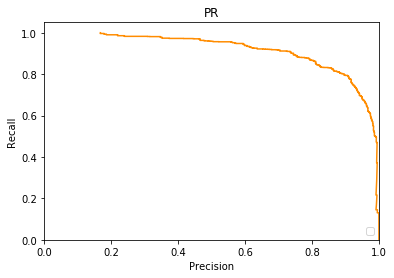

In [11]:
# e & f here
from sklearn.metrics import precision_recall_curve
P, R, t = precision_recall_curve(test_labels, net.predict_proba(test_images.transpose((0, 3, 1, 2)).astype(np.float32))[:, 1])

plt.figure()
lw = 2
plt.plot(P, R, color='darkorange')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('PR')
plt.legend(loc="lower right")
plt.show()

## Q2. Let's improve our model's performance

We will try several things below. Those steps are only indicative and you are free to pursue other means of improving your model.

Should you be lost, we refer you to the excellent "A Recipe for Training Neural Networks" article : https://karpathy.github.io/2019/04/25/recipe/

![image.png](https://github.com/rescallier/isae-practical-deep-learning/blob/master/docs/static/img/mlsystem.png?raw=1)

### a. Solving the imbalanced data problem

Go through your data: is the dataset balanced ? If now, which steps can I do to solve this imbalance problem ?

If you need help on this step, refer [to this tutorial on how to tackle imbalanced dataset](https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data)

- Which step would you take ?
- **Don't forget to apply the same step on you train and validation dataset**

Try to decide and a method to modify only the dataset and rerun your training. Did performance improve ?

In [0]:
# Q2.a here
idx_true = np.where(train_labels==1)
train_labels_2 = np.concatenate((train_labels.copy(),train_labels[idx_true].copy(),train_labels[idx_true].copy(),
                                 train_labels[idx_true].copy(),train_labels[idx_true].copy()))
train_images_2 = np.concatenate((train_images.copy(),train_images[idx_true].copy(),train_images[idx_true].copy(),
                                 train_images[idx_true].copy(),train_images[idx_true].copy()),axis=0)

In [0]:
module = nn.Sequential(
    nn.Conv2d(3, 64, 3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 64, 3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 64, 3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(6 * 6 * 64, 256),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 2),
    nn.Softmax(),
)

In [18]:
net = NeuralNetClassifier(
    module,
    max_epochs=10,
    lr=0.01,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    callbacks=[early_stopping],
    device="cuda" if torch.cuda.is_available() else "cpu",
    optimizer=optim.SGD)
net.fit(train_images_2.transpose((0, 3, 1, 2)).astype(np.float32), train_labels_2)

print("Confusion matrix")
confusion_matrix(test_labels, net.predict(test_images.transpose((0, 3, 1, 2)).astype(np.float32)))


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.2517       0.9359        0.1772  9.1396
      2        0.1264       0.6541        2.9573  9.0506
      3        0.0902       0.7176        1.2888  9.0986
      4        0.0712       0.9113        0.2815  9.1699
      5        0.0577       0.9250        0.1778  9.1095
Stopping since valid_loss has not improved in the last 5 epochs.
Confusion matrix


array([[13390,    14],
       [ 1220,   376]])

### b. Optimizer and model modifications

i ) Now that you have worked on your dataset and decided to undersample it, it's time to tune your network and your training configuration

In Session 1, you tested two descent gradient. What is the effect of its modification? Apply it to your training and compare metrics.

ii ) An other important parameter is the learning rate, you can [check its effect on the behavior of your training](https://developers.google.com/machine-learning/crash-course/fitter/graph).

iii) There is no absolute law concerning the structure of your deep Learning model. During the [Deep Learning class](https://github.com/erachelson/MLclass/blob/master/7%20-%20Deep%20Learning/Deep%20Learning.ipynb) you had an overview of existing models

You can operate a modification on your structure and observe the effect on final metrics. Of course, remain consistent with credible models, cf Layer Patterns chapter on this "must view" course : http://cs231n.github.io/convolutional-networks/

![image.png](https://github.com/rescallier/isae-practical-deep-learning/blob/master/docs/static/img/comparison_architectures.png?raw=1)

In [32]:
module = nn.Sequential(
    nn.Conv2d(3, 64, 3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout2d(),
    nn.Conv2d(64, 64, 3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout2d(),
    nn.Conv2d(64, 64, 3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Dropout2d(),
    nn.Flatten(),
    nn.Linear(6 * 6 * 64, 256),
    nn.Linear(256, 256),
    nn.ReLU(),
    nn.Linear(256, 2),
    nn.Softmax(),
)
# Use callbacks
 
early_stopping = EarlyStopping(monitor='valid_loss', lower_is_better=True)

net = NeuralNetClassifier(
    module,
    max_epochs=20,
    lr=0.01,
    # Shuffle training data on each epoch
    iterator_train__shuffle=True,
    callbacks=[early_stopping],
    device="cuda" if torch.cuda.is_available() else "cpu",
    optimizer=optim.SGD)
net.fit(train_images_2.transpose((0, 3, 1, 2)).astype(np.float32), train_labels_2)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.4501       0.8678        0.3279  9.4067
      2        0.3322       0.8999        0.2638  9.4296
      3        0.2787       0.9177        0.2191  9.3897
      4        0.2511       0.9148        0.2072  9.4088
      5        0.2302       0.9325        0.1794  9.3586
      6        0.2199       0.9389        0.1579  9.3608
      7        0.2080       0.9423        0.1495  9.4049
      8        0.1982       0.9493        0.1455  9.3571
      9        0.1894       0.9536        0.1322  9.3984
     10        0.1852       0.9510        0.1345  9.3972
     11        0.1784       0.9585        0.1235  9.3639
     12        0.1759       0.9585        0.1185  9.3189
     13        0.1670       0.9602        0.1165  9.4046
     14        0.1628       0.9532        0.1332  9.3780
     15        0.1602       0.9623        0.1084  9.4046
     16        0.1531       0.9

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.5, inplace=False)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout2d(p=0.5, inplace=False)
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout2d(p=0.5, inplace=False)
    (15): Flatten()
    (16): Linear(in_featu

### c. Going Further

Here is an overview of [possible hyperparameter tuning when training Convolutional Neural Networks](https://towardsdatascience.com/hyper-parameter-tuning-techniques-in-deep-learning-4dad592c63c8)

You can try and apply those techniques to your use case.

- Does these techniques yield good results ? What about the effort-spent-for-performance ratio ?
- Do you find it easy to keep track of your experiments ?
- What would you need to have a better overview of the effects of these search ?

Don't spend too much time on this part as the next is more important. You can come back to it after you're finished

In [0]:
# Q2.c here


## Q3. Full Test whole dataset & more improvements

a. Now that you have optimised your structure for your dataset, you will apply your model to the test dataset to see the final metrics. Plot all your metrics using the full imbalanced test set. Is it good enough ?
If you think so, you can apply it to new images using the sliding window technique with the 3rd notebook


Did it bring any improvements ?

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:92: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
No handles with labels found to put in legend.


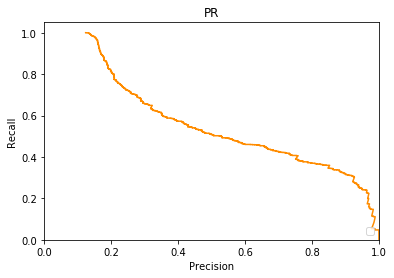

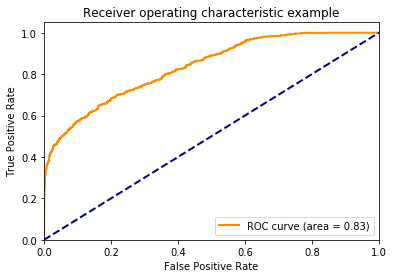

In [19]:
# Q3a
# e & f here
from sklearn.metrics import precision_recall_curve
P, R, t = precision_recall_curve(test_labels, net.predict_proba(test_images.transpose((0, 3, 1, 2)).astype(np.float32))[:, 1])

plt.figure()
lw = 2
plt.plot(P, R, color='darkorange')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('PR')
plt.legend(loc="lower right")
plt.show()

# Compute ROC curve and ROC area for each class
fpr, tpr, t = roc_curve(test_labels, net.predict_proba(test_images.transpose((0, 3, 1, 2)).astype(np.float32))[:, 1])
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

b. If you're not satisfied with the output of your model, consider the following idea: Training a new model with the failures of your previous model.
Try the following:
- Get all the images with the "aircraft" label
- Get all the images with the "background" label where your best model was wrong (predicted aircraft), as well as some of the background where it was right.
- Train a new model or retrain your existing one on this dataset.


In [0]:
# Q3b

c . **!!!! SAVE YOUR MODEL !!!**

https://skorch.readthedocs.io/en/latest/user/save_load.html#saving-and-loading

In [37]:
with open('model.pkl', 'wb') as f:
    pickle.dump(net, f)


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/usr/local/lib/python3.6/

**Have you saved your model ??** You will need it for the next notebook

In [35]:
!pip install pickle

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [0]:
import pickle